Run EDA first

In [2]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import numpy as np
#opties
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import miceforest as mf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import shap

c:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv(r'C:\Users\UNMAWI\OneDrive - VLC & Partners\Documenten\AAAAAAAAAAAAAScriptie\Scritpie+data\df_final.csv', sep=',')

In [4]:
df = df.drop(columns=['soort_klant'])

In [5]:
missing_percent = df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

aantal_documenten_slimdossier                                  72
aantal_werknemers                                              43
aantal_objecten                                                41
ewa_verzekerdbedrag                                            37
ewa_netto_premie                                               37
activiteiten                                                   31
processen_geopend                                              17
processen_afgesloten                                           17
processen_actief                                               17
processen_aantal                                               17
processen_open                                                 17
sbi_code                                                       11
minuten_soort_dvo_CLAIM                                         0
minuten_soort_dvo_OVERIG                                        0
freq_soort_dvo_ADVIES                                           0
minuten_so

NA invullen

Na miceforest imputatie:
 activiteiten            0
processen_geopend       0
processen_afgesloten    0
processen_open          0
processen_actief        0
processen_aantal        0
ewa_verzekerdbedrag     0
ewa_netto_premie        0
aantal_werknemers       0
dtype: int64


<Figure size 1000x600 with 0 Axes>

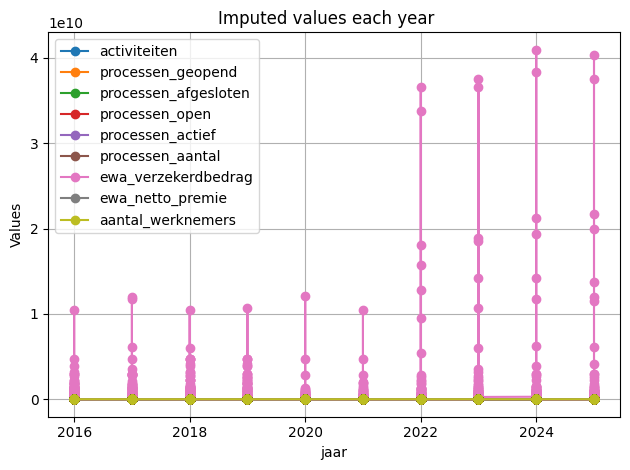

In [6]:
#sort
df = df.sort_values('jaar').reset_index(drop=True)

#add missing
df['aantal_werknemers_missing'] = df['aantal_werknemers'].isna()

#colums to impute
kolommen = [
    'activiteiten',
    'processen_geopend',
    'processen_afgesloten',
    'processen_open',
    'processen_actief',
    'processen_aantal',
    'ewa_verzekerdbedrag',
    'ewa_netto_premie',
    'aantal_werknemers',
    #'aantal_objecten',
]

#precitionrs extra
extra_predictors = [
    'schade',
    'jaar',
    'frequentie_taakregistratie',
"unieke_polissen_subbranche_AANSPRAKELIJKHEID",
"unieke_polissen_subbranche_BRAND",
"unieke_polissen_subbranche_KREDIET",
"unieke_polissen_subbranche_MEDISCHE VARIA",
"unieke_polissen_subbranche_MOTORRIJTUIGEN",
"unieke_polissen_subbranche_ONGEVALLEN",
"unieke_polissen_subbranche_RECHTSBIJSTAND",
"unieke_polissen_subbranche_REIS",
"unieke_polissen_subbranche_TRANSPORT",
"unieke_polissen_subbranche_VARIA",
"unieke_polissen_subbranche_ZIEKTEKOSTEN",
"unieke_polissen_coassurantiemaatschappij_soort_Adm. Volmacht",
"unieke_polissen_coassurantiemaatschappij_soort_Beurs",
"unieke_polissen_coassurantiemaatschappij_soort_Pakket",
"unieke_polissen_coassurantiemaatschappij_soort_Provinciaal",
"unieke_polissen_coassurantiemaatschappij_soort_Volmacht",
    'klantduur',
    #'aantal_objecten',
    'totaal_minuten'
]

alle_kolommen = kolommen + [col for col in extra_predictors if col not in kolommen]


missing_cols = [col for col in alle_kolommen if col not in df.columns]
if missing_cols:
    raise ValueError(f"De volgende kolommen ontbreken in df: {missing_cols}")

#config mice
kernel = mf.ImputationKernel(
    data=df[alle_kolommen],
    num_datasets=5,
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)

#impute
df_imputed = df.copy()
df_imputed[kolommen] = kernel.complete_data(dataset=0)[kolommen]

#check nans
print("Na miceforest imputatie:\n", df_imputed[kolommen].isna().sum())

#visualise results
plt.figure(figsize=(10, 6))
df_imputed.set_index('jaar')[kolommen].plot(marker='o')
plt.title('Imputed values each year   ')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
kolom_naam_mapping = {
    'activiteiten': 'activities',
    'processen_geopend': 'processes_opened',
    'processen_afgesloten': 'processes_closed',
    'processen_open': 'processes_ongoing',
    'processen_actief': 'processes_active',
    'processen_aantal': 'process_count',
    'ewa_verzekerdbedrag': 'insured_amount',
    'ewa_netto_premie': 'net_premium',
    'aantal_werknemers': 'employees'
}


In [8]:
df_plot = df_imputed[['jaar'] + kolommen].copy()
df_plot = df_plot.rename(columns=kolom_naam_mapping)


<Figure size 1000x600 with 0 Axes>

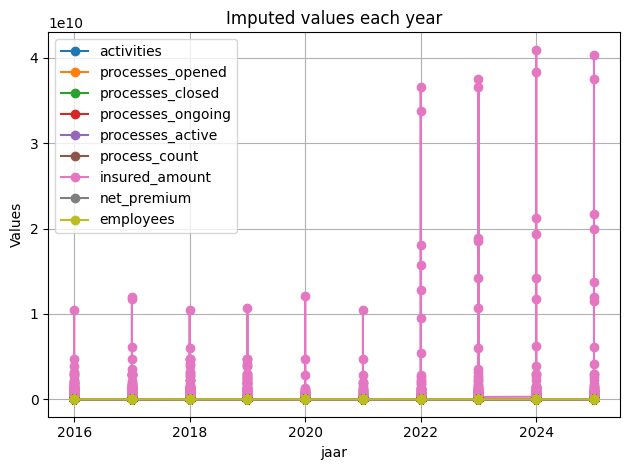

In [9]:
plt.figure(figsize=(10, 6))
df_plot.set_index('jaar').plot(marker='o')
plt.title('Imputed values each year')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
df = df_imputed
df['slimdossier_aanwezig'] = df['aantal_documenten_slimdossier'].notna().astype(int)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df.drop(columns='aantal_documenten_slimdossier', inplace=True)
df = df.drop(columns=['relatie_sinds','aantal_objecten'])
df['sbi_code'] = df['sbi_code'].fillna('na').astype(str)

DF voor Coldstart zie onder

In [11]:
df_coldstart = df.copy()

1 jaar

In [12]:
#pre process
df_lag = df.copy()
print(f"Oorspronkelijke dataset: {df_lag.shape}")
df_lag = df_lag.sort_values(['relatie_nummer_uuid', 'jaar'])

#define cols to lag
lag_cols = [
    'totaal_minuten', 'frequentie_taakregistratie','schade', 'unieke_werksoort',
    'unieke_dienst', 'unieke_gekoppeld_product', 'unieke_soort_dvo',
    'unieke_afdeling_dvo', 'unieke_soort_uren',
    'activiteiten', 'processen_geopend', 'processen_afgesloten', 'processen_aantal',
    'ewa_netto_premie', 'slimdossier_aanwezig','schade',
    'minuten_soort_dvo_ADVIES', 'minuten_soort_dvo_BEHEER', 'minuten_soort_dvo_CLAIM', 'minuten_soort_dvo_OVERIG',
    'freq_soort_dvo_ADVIES', 'freq_soort_dvo_BEHEER', 'freq_soort_dvo_CLAIM', 'freq_soort_dvo_OVERIG',
    'minuten_subbranche_AANSPRAKELIJKHEID', 'minuten_subbranche_BRAND', 'minuten_subbranche_KREDIET',
    'minuten_subbranche_LEVEN', 'minuten_subbranche_MEDISCHE VARIA', 'minuten_subbranche_MOTORRIJTUIGEN',
    'minuten_subbranche_ONGEVALLEN', 'minuten_subbranche_RECHTSBIJSTAND', 'minuten_subbranche_REIS',
    'minuten_subbranche_TRANSPORT', 'minuten_subbranche_VARIA', 'minuten_subbranche_ZIEKTEKOSTEN',
    'freq_subbranche_AANSPRAKELIJKHEID', 'freq_subbranche_BRAND', 'freq_subbranche_KREDIET',
    'freq_subbranche_LEVEN', 'freq_subbranche_MEDISCHE VARIA', 'freq_subbranche_MOTORRIJTUIGEN',
    'freq_subbranche_ONGEVALLEN', 'freq_subbranche_RECHTSBIJSTAND', 'freq_subbranche_REIS',
    'freq_subbranche_TRANSPORT', 'freq_subbranche_VARIA', 'freq_subbranche_ZIEKTEKOSTEN',
    'minuten_coassurantiemaatschappij_soort_Adm. Volmacht', 'minuten_coassurantiemaatschappij_soort_Beurs',
    'minuten_coassurantiemaatschappij_soort_Pakket', 'minuten_coassurantiemaatschappij_soort_Provinciaal',
    'minuten_coassurantiemaatschappij_soort_Volmacht',
    'freq_coassurantiemaatschappij_soort_Adm. Volmacht', 'freq_coassurantiemaatschappij_soort_Beurs',
    'freq_coassurantiemaatschappij_soort_Pakket', 'freq_coassurantiemaatschappij_soort_Provinciaal',
    'freq_coassurantiemaatschappij_soort_Volmacht'
]
pol_cols = [
"unieke_polissen_soort_dvo_ADVIES",
"unieke_polissen_soort_dvo_BEHEER",
"unieke_polissen_soort_dvo_CLAIM",
"unieke_polissen_soort_dvo_OVERIG",      
"unieke_polissen_subbranche_AANSPRAKELIJKHEID",
"unieke_polissen_subbranche_BRAND",
"unieke_polissen_subbranche_KREDIET",
"unieke_polissen_subbranche_MEDISCHE VARIA",
"unieke_polissen_subbranche_MOTORRIJTUIGEN",
"unieke_polissen_subbranche_ONGEVALLEN",
"unieke_polissen_subbranche_RECHTSBIJSTAND",
"unieke_polissen_subbranche_REIS",
"unieke_polissen_subbranche_TRANSPORT",
"unieke_polissen_subbranche_VARIA",
"unieke_polissen_subbranche_ZIEKTEKOSTEN",
"unieke_polissen_coassurantiemaatschappij_soort_Adm. Volmacht",
"unieke_polissen_coassurantiemaatschappij_soort_Beurs",
"unieke_polissen_coassurantiemaatschappij_soort_Pakket",
"unieke_polissen_coassurantiemaatschappij_soort_Provinciaal",
"unieke_polissen_coassurantiemaatschappij_soort_Volmacht",
#'aantal_objecten', 
'ewa_verzekerdbedrag',
"ewa_min_per_polis_subbranche_AANSPRAKELIJKHEID",
"ewa_min_per_polis_subbranche_BRAND",
"ewa_min_per_polis_subbranche_DVO DOORLOPEND VAST",
"ewa_min_per_polis_subbranche_KREDIET",
"ewa_min_per_polis_subbranche_LEVEN",
"ewa_min_per_polis_subbranche_MEDISCHE VARIA",
"ewa_min_per_polis_subbranche_MOTORRIJTUIGEN",
"ewa_min_per_polis_subbranche_ONGEVALLEN",
"ewa_min_per_polis_subbranche_RECHTSBIJSTAND",
"ewa_min_per_polis_subbranche_REIS",
"ewa_min_per_polis_subbranche_TRANSPORT",
"ewa_min_per_polis_subbranche_VARIA",
"ewa_min_per_polis_subbranche_ZIEKTEKOSTEN",
]

#lag the columns
def make_lagged(df, cols, lag=1):
    grp = df.groupby('relatie_nummer_uuid')
    return pd.DataFrame({
        f"{c}_tminus{lag}": grp[c].shift(lag)
        for c in cols
    }, index=df.index)

df_lagged = pd.concat([
    make_lagged(df_lag, lag_cols, lag=1),
    make_lagged(df_lag, pol_cols, lag=1)
], axis=1)

#concat to df
df_lag = pd.concat([df_lag, df_lagged], axis=1)
print(f"Na toevoegen lagged features: {df_lag.shape}")

#keep rows with lag features
lagged_cols = [c + '_tminus1' for c in lag_cols + pol_cols]
df_lag = df_lag.dropna(subset=lagged_cols, how='any').reset_index(drop=True)
print(f"Na verwijderen ontbrekende t-1: {df_lag.shape}")

# ===== 5. Bereken delta & pct-groei voor pol_cols =====
for c in pol_cols:
    df_lag[f'delta_{c}'] = df_lag[c] - df_lag[f'{c}_tminus1']
    df_lag[f'pctgroei_{c}'] = (
        df_lag[f'delta_{c}'] / df_lag[f'{c}_tminus1'].replace(0, pd.NA)
    ).fillna(0)

# ===== 6. Drop originele lag_cols, behoud pol_cols en target =====
target = df_lag['totaal_minuten'].copy()
df_lag = df_lag.drop(columns=lag_cols)
df_lag['totaal_minuten'] = target

print(f"✅ df_lag is klaar: {df_lag.shape[0]} rijen, {df_lag.shape[1]} kolommen.")


Oorspronkelijke dataset: (96166, 106)
Na toevoegen lagged features: (96166, 197)
Na verwijderen ontbrekende t-1: (68157, 197)


C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sile

✅ df_lag is klaar: 68157 rijen, 209 kolommen.


C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\2661951630.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sile

In [13]:
df = df_lag

df['sbi_sector'] = df['sbi_code'].str[:2]
df = pd.get_dummies(
    df,
    columns=['sbi_sector'],
    prefix=['sbi',],
    drop_first=False,
    dtype=bool 
)
df = df.drop(columns=['sbi_code'])
df_lag = df

In [14]:
#config split
df_filtered = df_lag[df_lag['jaar'] <= 2024]
train_df    = df_filtered[df_filtered['jaar'] <= 2023]
test_df     = df_filtered[df_filtered['jaar'] == 2024]

#what are the sizes
print("Train na filter:", len(train_df))
print("Test  na filter:", len(test_df))


Train na filter: 51656
Test  na filter: 9918


In [15]:
freq = train_df['correspondentie_woonplaats'].value_counts()
train_df['loc_freq'] = train_df['correspondentie_woonplaats'].map(freq)
#map the frequeantie of the locations
test_df['loc_freq'] = test_df['correspondentie_woonplaats'].map(freq).fillna(0)

C:\Users\matth\AppData\Local\Temp\ipykernel_27812\4265492981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['loc_freq'] = train_df['correspondentie_woonplaats'].map(freq)
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\4265492981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['loc_freq'] = test_df['correspondentie_woonplaats'].map(freq).fillna(0)


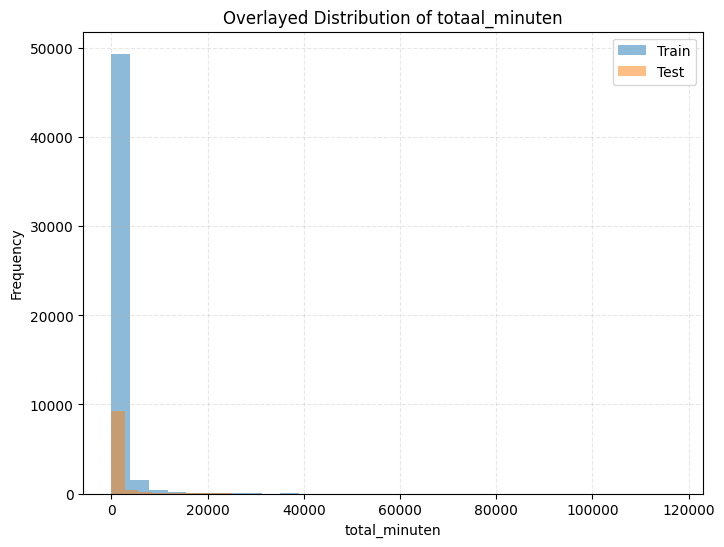

In [16]:

plt.figure(figsize=(8, 6))
plt.hist(
    train_df['totaal_minuten'].dropna(),
    bins=30,
    alpha=0.5,
    label='Train'
)
plt.hist(
    test_df['totaal_minuten'].dropna(),
    bins=30,
    alpha=0.5,
    label='Test'
)
plt.xlabel('total_minuten')
plt.ylabel('Frequency')
plt.title('Overlayed Distribution of totaal_minuten')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.show()

Powertransfer

In [17]:
from sklearn.preprocessing import PowerTransformer

def apply_yeo_johnson_transformation(train_df, test_df, target_col='totaal_minuten', skew_threshold=3):
    transformer = PowerTransformer(method='yeo-johnson')

    #select numerical columns
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop(target_col)
    skewness = train_df[numeric_cols].skew()
    cols_to_transform = skewness[abs(skewness) > skew_threshold].index.tolist()

    #cast as float
    train_df[cols_to_transform] = train_df[cols_to_transform].astype(float)
    test_df[cols_to_transform]  = test_df[cols_to_transform].astype(float)

    #chekc what to tranform
    train_df[cols_to_transform] = transformer.fit_transform(train_df[cols_to_transform])
    test_df[cols_to_transform]  = transformer.transform(test_df[cols_to_transform])

    return train_df, test_df, cols_to_transform, transformer


In [18]:

train_df_transformed, test_df_transformed, transformed_cols, yeo_transformer = apply_yeo_johnson_transformation(
    train_df.copy(), test_df.copy(), target_col='totaal_minuten', skew_threshold=3
)
target_transformer = PowerTransformer(method='yeo-johnson')

LOG1 op target

In [19]:
train_df_transformed['totaal_minuten'] = np.log1p(train_df['totaal_minuten'])
test_df_transformed['totaal_minuten'] = np.log1p(test_df['totaal_minuten'])


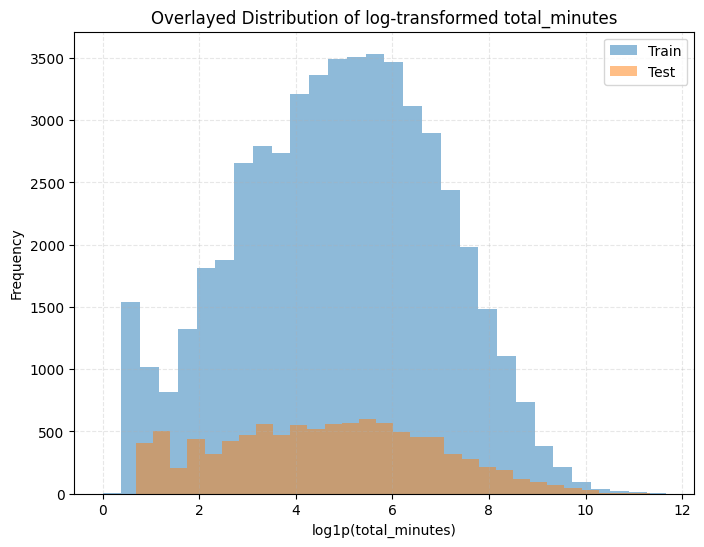

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(
    train_df_transformed['totaal_minuten'].dropna(),
    bins=30,
    alpha=0.5,
    label='Train'
)
plt.hist(
    test_df_transformed['totaal_minuten'].dropna(),
    bins=30,
    alpha=0.5,
    label='Test'
)
plt.xlabel('log1p(total_minutes)')
plt.ylabel('Frequency')
plt.title('Overlayed Distribution of log-transformed total_minutes')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.show()


In [21]:
print(test_df_transformed[['correspondentie_woonplaats', 'loc_freq']].sample(10))
print(test_df_transformed['loc_freq'].describe())

      correspondentie_woonplaats  loc_freq
1139                    ROERMOND       174
46098                 LEIDERDORP        30
63126                 OOSTERHOUT        90
58288                    HEERLEN       297
53326                    ZAANDAM       232
6751                ALBLASSERDAM        99
15149                      WEERT       288
54175                     EEMNES        20
38754                  AMSTERDAM      4467
30944                    UTRECHT      2269
count   9918
mean     695
std     1235
min        0
25%       40
50%      163
75%      501
max     4467
Name: loc_freq, dtype: float64


In [22]:
#choose and make bins
_, raw_bins = pd.qcut(
    train_df_transformed['totaal_minuten_tminus1'],
    q=10,
    labels=False,
    retbins=True,
    duplicates='drop'
)

bins = raw_bins.copy()
bins[0]  = -np.inf
bins[-1] =  np.inf


#bins function
def apply_klant_grootte(df, source_col, bins, new_col='klant_grootte'):
    labels = list(range(1, len(bins)))
    df[new_col] = pd.cut(
        df[source_col],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype('Int64')
    df[new_col] = df[new_col].fillna(0).astype(int)
    return df


train_df_transformed = apply_klant_grootte(
    train_df_transformed,
    source_col='totaal_minuten_tminus1',
    bins=bins
)
test_df_transformed = apply_klant_grootte(
    test_df_transformed,
    source_col='totaal_minuten_tminus1',
    bins=bins
)



# check sizes
print("Train klant_grootte counts:")
print(train_df_transformed['klant_grootte'].value_counts().sort_index())

print("\nTest klant_grootte counts:")
print(test_df_transformed['klant_grootte'].value_counts().sort_index())



Train klant_grootte counts:
klant_grootte
1     5181
2     5238
3     5098
4     5278
5     5073
6     5135
7     5171
8     5156
9     5160
10    5166
Name: count, dtype: int64

Test klant_grootte counts:
klant_grootte
1     1310
2     1077
3     1002
4     1015
5      951
6      992
7      940
8      908
9      859
10     864
Name: count, dtype: int64


C:\Users\matth\AppData\Local\Temp\ipykernel_27812\3357892914.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = pd.cut(
C:\Users\matth\AppData\Local\Temp\ipykernel_27812\3357892914.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = pd.cut(


In [23]:
DL_train = train_df_transformed
DL_test = test_df_transformed

Model

In [24]:
#actual model training and testing
#helper
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def print_metrics_original_scale(y_true, y_pred, name):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    mae  = mean_absolute_error(y_true_orig, y_pred_orig)
    r2   = r2_score(y_true_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_true_orig, y_pred_orig)
    print(f"{name} → MAE: {mae:.2f} min | R²: {r2:.4f} | MAPE: {mape:.2f}%")

# pre
X_train_all = train_df_transformed.select_dtypes(include=[np.number]).drop(columns=['totaal_minuten'])
y_train_all = train_df_transformed['totaal_minuten']
X_test      = test_df_transformed.select_dtypes(include=[np.number]).drop(columns=['totaal_minuten'])
y_test      = test_df_transformed['totaal_minuten']

# config
scoring  = 'neg_mean_absolute_error'
outer_cv = TimeSeriesSplit(n_splits=5)
inner_cv = TimeSeriesSplit(n_splits=3)

base_models = {
    'RF':  RandomForestRegressor(random_state=42),
    'Ada': AdaBoostRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42, verbosity=0)
}

param_grids = {
    'RF':  { 'n_estimators': [75,100,150,200], 'max_depth': [3, 5, 10, 15,None], 'min_samples_leaf': [1,5,7] },
    'Ada': { 'n_estimators': [75,100,150,200], 'learning_rate': [0.5,0.1,0.05,0.01] },
    'XGB': { 'n_estimators': [75,100,150,200], 'learning_rate': [0.5,0.1,0.05,0.01], 'max_depth': [3, 5, 10, 15], 'colsample_bytree':[0.7, 0.8, 0.9] }
}

# ── RFE outside CV (per model) ─────────────────────────────────────────────
selected_features = {}
reduced_X_train_all = {}
reduced_X_test = {}

for name, model in base_models.items():
    print(f"Running RFE for {name}...")
    rfe = RFE(model, n_features_to_select=30, step=0.1)
    rfe.fit(X_train_all, y_train_all)
    selected = X_train_all.columns[rfe.support_]
    selected_features[name] = selected.tolist()

    reduced_X_train_all[name] = X_train_all[selected]
    reduced_X_test[name] = X_test[selected]

# ── Nested CV and final evaluation ─────────────────────────────────────────
nested_results = {}
model_outputs = {}

for name, model in base_models.items():
    print(f"\n=== Nested-CV for {name} ===")
    
    gs = GridSearchCV(
        estimator        = model,
        param_grid       = param_grids[name],
        cv               = inner_cv,
        scoring          = scoring,
        return_train_score = True,
        n_jobs           = -1,
        verbose          = 1,
        refit            = True
    )
    
    outer_scores = cross_val_score(
        gs,
        reduced_X_train_all[name],
        y_train_all,
        cv=outer_cv,
        scoring=scoring,
        n_jobs=-1
    )
    
    mae_outer = -outer_scores
    print(f"{name} | Outer CV MAE: {mae_outer.mean():.2f} ± {mae_outer.std():.2f} min")
    
    nested_results[name] = {
        'gs': gs,
        'outer_mae': mae_outer
    }

    # Retrain on full pre-2024 set
    gs.fit(reduced_X_train_all[name], y_train_all)
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    nested_results[name]['best_params'] = best_params
    print(f"Beste hyperparameters voor {name}: {best_params}")

    # Predictions
    y_train_pred = best_model.predict(reduced_X_train_all[name])
    y_test_pred  = best_model.predict(reduced_X_test[name])
    
    y_train_pred_orig = np.expm1(y_train_pred)
    y_train_true_orig = np.expm1(y_train_all)
    y_test_pred_orig  = np.expm1(y_test_pred)
    y_test_true_orig  = np.expm1(y_test)
    
    print_metrics_original_scale(y_train_all, y_train_pred, f"{name} | Train (pre-2024)")
    print_metrics_original_scale(y_test, y_test_pred, f"{name} | Final Test 2024")
    
    model_outputs[name] = {
        'model': best_model,
        'selected_features': selected_features[name],
        'y_train_pred': y_train_pred_orig,
        'y_train_true': y_train_true_orig,
        'y_test_pred': y_test_pred_orig,
        'y_test_true': y_test_true_orig
    }

param_df = pd.DataFrame([
    {
        'model': name,
        'mean_outer_mae': nested_results[name]['outer_mae'].mean(),
        **nested_results[name]['best_params']
    }
    for name in nested_results
])


display(param_df)

#save CSV
param_df.to_csv("beste_hyperparameters_per_model.csv", index=False)

#choose best model
winner = min(nested_results, key=lambda k: nested_results[k]['outer_mae'].mean())
print(f"\n✅ Beste model volgens nested CV: {winner}")


Running RFE for RF...
Running RFE for Ada...
Running RFE for XGB...

=== Nested-CV for RF ===
RF | Outer CV MAE: 0.92 ± 0.02 min
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Beste hyperparameters voor RF: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 200}
RF | Train (pre-2024) → MAE: 279.02 min | R²: 0.8118 | MAPE: 85.67%
RF | Final Test 2024 → MAE: 480.24 min | R²: 0.5291 | MAPE: 221.54%

=== Nested-CV for Ada ===
Ada | Outer CV MAE: 1.08 ± 0.00 min
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Beste hyperparameters voor Ada: {'learning_rate': 0.1, 'n_estimators': 150}
Ada | Train (pre-2024) → MAE: 562.40 min | R²: 0.2172 | MAPE: 242.94%
Ada | Final Test 2024 → MAE: 608.23 min | R²: 0.1972 | MAPE: 288.82%

=== Nested-CV for XGB ===
XGB | Outer CV MAE: 0.90 ± 0.01 min
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Beste hyperparameters voor XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 2

,model,mean_outer_mae,max_depth,min_samples_leaf,n_estimators,learning_rate,colsample_bytree
0,RF,1,NaN,5,200,NaN,NaN
1,Ada,1,NaN,NaN,150,0,NaN
2,XGB,1,5,NaN,200,0,1



✅ Beste model volgens nested CV: XGB


In [25]:
# Extract test predictions for plotting and evaluation
y_pred_xgb = model_outputs['XGB']['y_test_pred']
y_pred_rfr = model_outputs['RF']['y_test_pred']
y_pred_ada = model_outputs['Ada']['y_test_pred']
y_true     = model_outputs['XGB']['y_test_true']


MAE's

In [26]:

#per bin mean of train set
train_eval = train_df_transformed.copy()
train_eval['y_true_orig'] = np.expm1(train_eval['totaal_minuten'])
group_means = train_eval.groupby('klant_grootte')['y_true_orig'].mean()

#Creat Dv_eval
df_eval = test_df_transformed.copy()
df_eval['y_true']        = np.expm1(y_test)                        # echte minuten
df_eval['y_pred']        = np.expm1(y_test_pred)                   # XGB‐model
MAX_EXP_INPUT = 700  # veilige bovengrens voor np.expm1

df_eval['rfr_pred'] = y_pred_rfr
df_eval['ada_pred'] = y_pred_ada



df_eval['abs_err_xgb'] = (df_eval['y_true'] - df_eval['y_pred']).abs().astype(float)
df_eval['abs_err_rfr'] = (df_eval['y_true'] - df_eval['rfr_pred']).abs().astype(float)
df_eval['abs_err_ada'] = (df_eval['y_true'] - df_eval['ada_pred']).abs().astype(float)

#Baseline 1: bin‐mean uit train
df_eval['baseline_pred'] = df_eval['klant_grootte'].map(group_means)
df_eval['baseline_pred'] = df_eval['baseline_pred'].fillna(group_means.mean())
df_eval['baseline_err']  = (df_eval['y_true'] - df_eval['baseline_pred']).abs()

#Baseline 2: t–1 naive
df_eval['tminus1_pred'] = np.expm1(df_eval['totaal_minuten_tminus1'])
df_eval['tminus1_err']  = (df_eval['y_true'] - df_eval['tminus1_pred']).abs()

#Per‐groep summary: MAE model vs. 2 baselines, gemiddelde duur, count
summary_per_group = (
    df_eval
    .groupby('klant_grootte', as_index=False)
    .agg(
        MAE_XGB         = ('abs_err_xgb',     'mean'),
        MAE_RF          = ('abs_err_rfr',     'mean'),
        MAE_Ada         = ('abs_err_ada',     'mean'),
        MAE_bin_mean    = ('baseline_err',    'mean'),
        MAE_tminus1     = ('tminus1_err',     'mean'),
        Mean_duration   = ('y_true',          'mean'),
        n_obs           = ('y_true',          'size')
    )
    .sort_values('klant_grootte')
)
print(summary_per_group)
#Normaliseer MAEs per klantgroepgrootte
print(summary_per_group[['klant_grootte', 'MAE_XGB', 'Mean_duration']])

summary_per_group['nMAE_XGB']      = summary_per_group['MAE_XGB'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_RF']       = summary_per_group['MAE_RF'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_Ada']      = summary_per_group['MAE_Ada'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_bin_mean'] = summary_per_group['MAE_bin_mean'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_tminus1']  = summary_per_group['MAE_tminus1'] / summary_per_group['Mean_duration']

#Overall MAE voor model en beide baselines
overall_mae_model     = mean_absolute_error(df_eval['y_true'], df_eval['y_pred'])
overall_mae_bin_mean  = mean_absolute_error(df_eval['y_true'], df_eval['baseline_pred'])
overall_mae_tminus1   = mean_absolute_error(df_eval['y_true'], df_eval['tminus1_pred'])

print(f"\nOverall model MAE:       {overall_mae_model:.2f} min")
print(f"Overall bin‐mean MAE:    {overall_mae_bin_mean:.2f} min")
print(f"Overall t–1 baseline MAE:{overall_mae_tminus1:.2f} min")


   klant_grootte  MAE_XGB  MAE_RF  MAE_Ada  MAE_bin_mean  MAE_tminus1  \
0              1       65      66       73           114           84   
1              2      102     101      109           164          129   
2              3      101     103      109           172          136   
3              4      141     144      152           219          189   
4              5      171     175      194           273          240   
5              6      264     265      297           374          380   
6              7      294     291      332           438          451   
7              8      486     493      571           700          766   
8              9     1018    1032     1173          1311         1564   
9             10     2661    2640     3749          4090         5121   

   Mean_duration  n_obs  
0             84   1310  
1            128   1077  
2            135   1002  
3            189   1015  
4            240    951  
5            380    992  
6            4

In [27]:
#MAE ≠ Mean_duration
print(summary_per_group[['klant_grootte', 'MAE_XGB', 'Mean_duration']])
for i, row in summary_per_group.iterrows():
    klant = row['klant_grootte']
    mae = row['MAE_XGB']
    dur = row['Mean_duration']
    print(f"Klantgroep {klant}: MAE = {mae}, Mean_duration = {dur}, nMAE = {mae/dur}")

#nMAE's
summary_per_group['nMAE_XGB'] = summary_per_group['MAE_XGB'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_RF'] = summary_per_group['MAE_RF'] / summary_per_group['Mean_duration']
summary_per_group['nMAE_Ada'] = summary_per_group['MAE_Ada'] / summary_per_group['Mean_duration']

#print
print(summary_per_group[['klant_grootte', 'nMAE_XGB', 'nMAE_RF', 'nMAE_Ada']].round(3))


   klant_grootte  MAE_XGB  Mean_duration
0              1       65             84
1              2      102            128
2              3      101            135
3              4      141            189
4              5      171            240
5              6      264            380
6              7      294            452
7              8      486            767
8              9     1018           1566
9             10     2661           5126
Klantgroep 1.0: MAE = 64.592902806515, Mean_duration = 83.54198473282443, nMAE = 0.7731789352753531
Klantgroep 2.0: MAE = 101.52468629157865, Mean_duration = 128.26833797585886, nMAE = 0.7915023137719802
Klantgroep 3.0: MAE = 101.03336724287973, Mean_duration = 135.42914171656687, nMAE = 0.7460238318155158
Klantgroep 4.0: MAE = 140.56346799963214, Mean_duration = 188.63546798029557, nMAE = 0.7451592720321031
Klantgroep 5.0: MAE = 171.0177842384884, Mean_duration = 239.84752891692955, nMAE = 0.7130270843762575
Klantgroep 6.0: MAE = 263.67185298

In [28]:
print(summary_per_group.dtypes)


klant_grootte      int64
MAE_XGB          float64
MAE_RF           float64
MAE_Ada          float64
MAE_bin_mean     float64
MAE_tminus1      float64
Mean_duration    float64
n_obs              int64
nMAE_XGB         float64
nMAE_RF          float64
nMAE_Ada         float64
nMAE_bin_mean    float64
nMAE_tminus1     float64
dtype: object


In [29]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

#Prepare evaluation sets 
train_eval = train_df_transformed.copy()
train_eval['y_true'] = np.expm1(train_eval['totaal_minuten'])
train_eval['tminus1_pred'] = np.expm1(train_eval['totaal_minuten_tminus1'])
train_eval['baseline_pred'] = train_eval['klant_grootte'].map(group_means)
train_eval['baseline_pred'] = train_eval['baseline_pred'].fillna(group_means.mean())

test_eval = test_df_transformed.copy()
test_eval['y_true'] = np.expm1(y_test)
test_eval['y_pred'] = np.expm1(y_test_pred)
test_eval['tminus1_pred'] = np.expm1(test_eval['totaal_minuten_tminus1'])
test_eval['baseline_pred'] = test_eval['klant_grootte'].map(group_means)
test_eval['baseline_pred'] = test_eval['baseline_pred'].fillna(group_means.mean())

#TRAIN set
mae_bin_train  = mean_absolute_error(train_eval['y_true'], train_eval['baseline_pred'])
r2_bin_train   = r2_score(train_eval['y_true'], train_eval['baseline_pred'])
mape_bin_train = mean_absolute_percentage_error(train_eval['y_true'], train_eval['baseline_pred']) * 100

mae_t1_train  = mean_absolute_error(train_eval['y_true'], train_eval['tminus1_pred'])
r2_t1_train   = r2_score(train_eval['y_true'], train_eval['tminus1_pred'])
mape_t1_train = mean_absolute_percentage_error(train_eval['y_true'], train_eval['tminus1_pred']) * 100

#TEST set
mae_bin_test  = mean_absolute_error(test_eval['y_true'], test_eval['baseline_pred'])
r2_bin_test   = r2_score(test_eval['y_true'], test_eval['baseline_pred'])
mape_bin_test = mean_absolute_percentage_error(test_eval['y_true'], test_eval['baseline_pred']) * 100

mae_t1_test  = mean_absolute_error(test_eval['y_true'], test_eval['tminus1_pred'])
r2_t1_test   = r2_score(test_eval['y_true'], test_eval['tminus1_pred'])
mape_t1_test = mean_absolute_percentage_error(test_eval['y_true'], test_eval['tminus1_pred']) * 100


print("Baseline: Bin-Mean")
print(f"Train: MAE={mae_bin_train:.2f}, R²={r2_bin_train:.3f}, MAPE={mape_bin_train:.2f}%")
print(f"Test:  MAE={mae_bin_test:.2f}, R²={r2_bin_test:.3f}, MAPE={mape_bin_test:.2f}%\n")

print("Baseline: Lag t–1")
print(f"Train: MAE={mae_t1_train:.2f}, R²={r2_t1_train:.3f}, MAPE={mape_t1_train:.2f}%")
print(f"Test:  MAE={mae_t1_test:.2f}, R²={r2_t1_test:.3f}, MAPE={mape_t1_test:.2f}%")


Baseline: Bin-Mean
Train: MAE=661.11, R²=0.271, MAPE=4520037939720838.00%
Test:  MAE=711.68, R²=0.276, MAPE=1900.10%

Baseline: Lag t–1
Train: MAE=790.65, R²=-0.109, MAPE=12043554767909.20%
Test:  MAE=813.81, R²=-0.096, MAPE=103.68%


Plots

In [30]:
# MAKE SURE YOU HAVE PRED READY
df_eval['resid_xgb'] = df_eval['y_true'] - df_eval['y_pred']
df_eval['resid_rfr'] = df_eval['y_true'] - df_eval['rfr_pred']
df_eval['resid_ada'] = df_eval['y_true'] - df_eval['ada_pred']


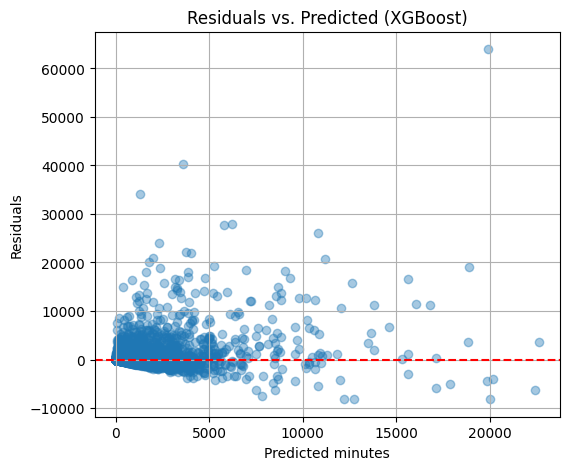

In [31]:


plt.figure(figsize=(6, 5))
plt.scatter(df_eval['y_pred'], df_eval['resid_xgb'], alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted (XGBoost)')
plt.xlabel('Predicted minutes')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


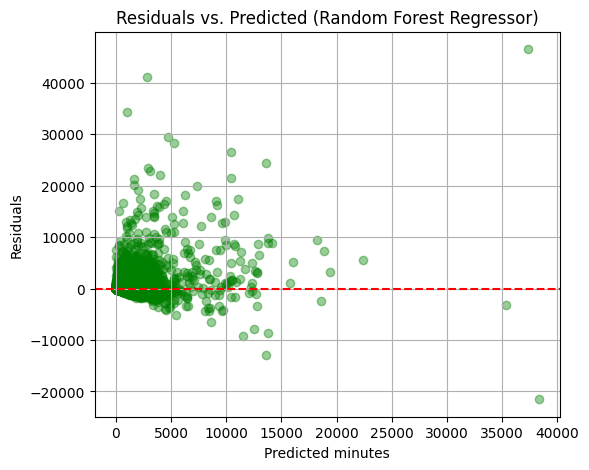

In [32]:
plt.figure(figsize=(6, 5))
plt.scatter(df_eval['rfr_pred'], df_eval['resid_rfr'], alpha=0.4, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted (Random Forest Regressor)')
plt.xlabel('Predicted minutes')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


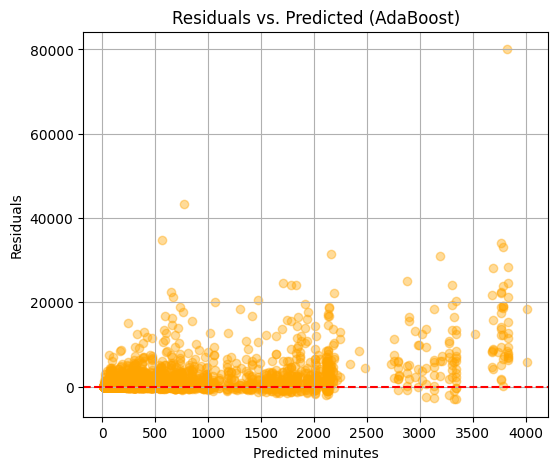

In [33]:
plt.figure(figsize=(6, 5))
plt.scatter(df_eval['ada_pred'], df_eval['resid_ada'], alpha=0.4, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted (AdaBoost)')
plt.xlabel('Predicted minutes')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


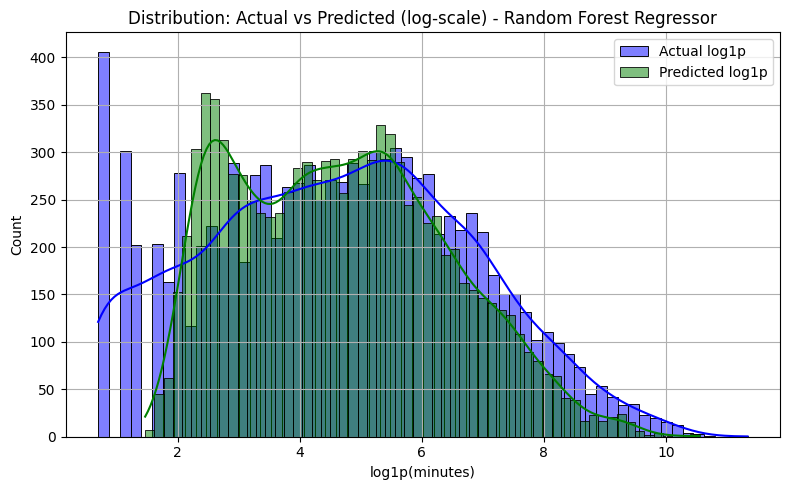

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_eval['y_true']), kde=True, stat='count', label='Actual log1p', color='blue', bins=60)
sns.histplot(np.log1p(df_eval['rfr_pred']), kde=True, stat='count', label='Predicted log1p', color='green', bins=60)
plt.title("Distribution: Actual vs Predicted (log-scale) - Random Forest Regressor")
plt.xlabel("log1p(minutes)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


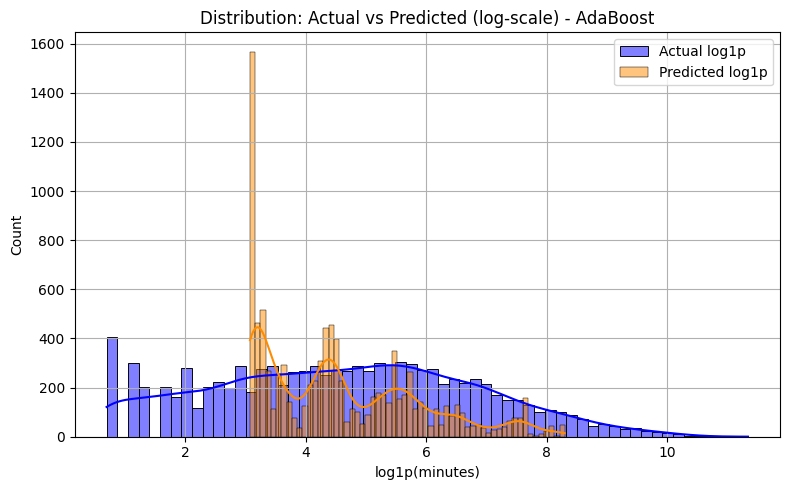

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_eval['y_true']), kde=True, stat='count', label='Actual log1p', color='blue', bins=60)
sns.histplot(np.log1p(df_eval['ada_pred']), kde=True, stat='count', label='Predicted log1p', color='darkorange', bins=60)
plt.title("Distribution: Actual vs Predicted (log-scale) - AdaBoost")
plt.xlabel("log1p(minutes)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


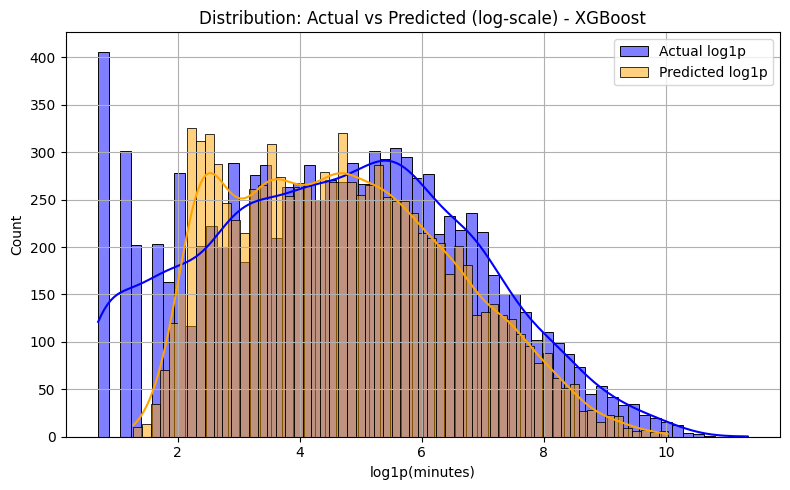

In [36]:


plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df_eval['y_true']), kde=True, stat='count', label='Actual log1p', color='blue', bins=60)
sns.histplot(np.log1p(df_eval['y_pred']), kde=True, stat='count', label='Predicted log1p', color='orange', bins=60)
plt.title("Distribution: Actual vs Predicted (log-scale) - XGBoost")
plt.xlabel("log1p(minutes)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
name_map = {
    'totaal_minuten_tminus1': 'total_minutes_tminus1',
    'frequentie_taakregistratie_tminus1': 'task_frequency_tminus1',
    'unieke_polissen_soort_dvo_OVERIG': 'unique_policies_type_OTHER',
    'unieke_polissen_soort_dvo_BEHEER': 'unique_policies_type_MANAGEMENT',
    'unieke_polissen_soort_dvo_CLAIM': 'unique_policies_type_CLAIM',
    'unieke_polissen_soort_dvo_ADVIES': 'unique_policies_type_ADVICE',
    'pctgroei_unieke_polissen_soort_dvo_BEHEER': 'percent_growth_policies_MANAGEMENT',
    'pctgroei_unieke_polissen_soort_dvo_CLAIM': 'percent_growth_policies_CLAIM',
    'pctgroei_unieke_polissen_soort_dvo_OVERIG': 'percent_growth_policies_OTHER',
    'unieke_polissen_coassurantiemaatschappij_soort_Beurs': 'unique_policies_coinsurer_TYPE_Exchange',
    'unieke_polissen_coassurantiemaatschappij_soort_Volmacht': 'unique_policies_coinsurer_TYPE_Authority',
    'minuten_soort_dvo_BEHEER_tminus1': 'minutes_type_MANAGEMENT_tminus1',
    'minuten_soort_dvo_OVERIG_tminus1': 'minutes_type_OTHER_tminus1',
    'delta_unieke_polissen_soort_dvo_CLAIM': 'delta_unique_policies_CLAIM',
    'unieke_polissen_subbranche_BRAND': 'unique_policies_subbranch_FIRE',
    'unieke_dienst_tminus1': 'unique_department_tminus1',
    'unieke_soort_dvo_tminus1': 'unique_policy_type_tminus1',
    'processen_open': 'processes_open',
    'processen_actief': 'processes_active',
}


Shap


 98%|===================| 9750/9918 [00:28<00:00]        

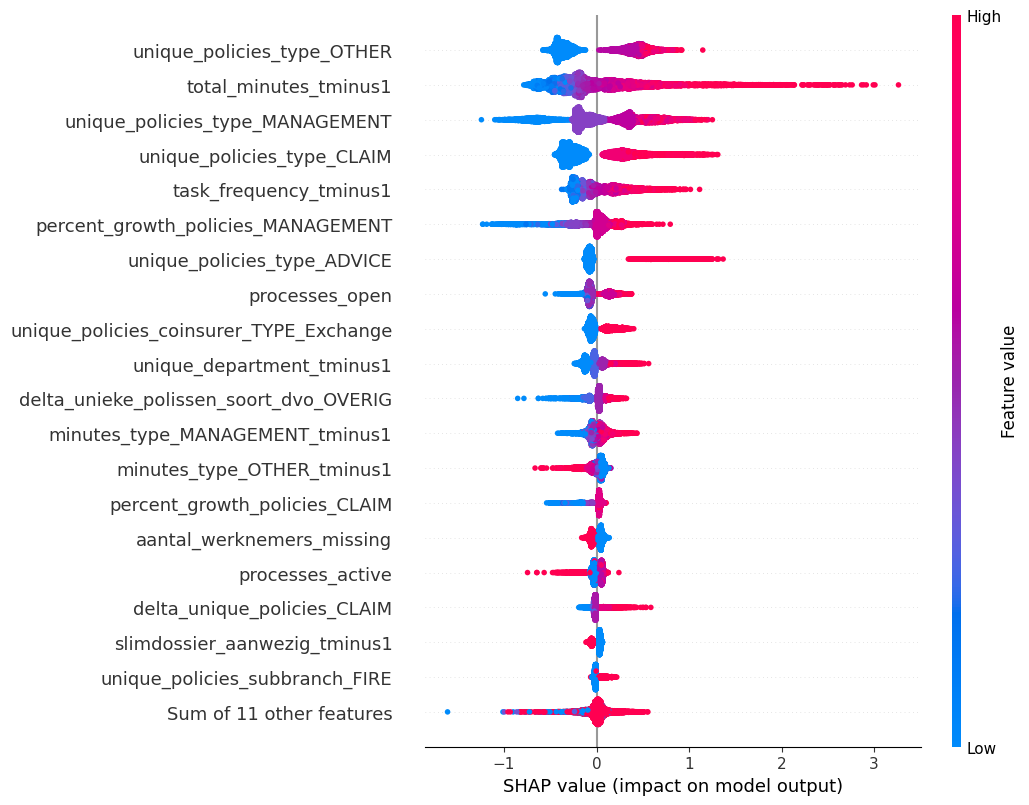

In [38]:



explainer = shap.Explainer(model_outputs['XGB']['model'], X_test[selected_features['XGB']])

shap_values = explainer(X_test[selected_features['XGB']])
shap_values.feature_names = [name_map.get(f, f) for f in shap_values.feature_names]
shap.plots.beeswarm(shap_values, max_display=20)
df_eval_english = df_eval.rename(columns=name_map)
